<img src="images/hotel.jpg" alt="example" style="width:1500px; height:500px;">

# Eco Oasis Suites: Investigating Hotel Reservation Cancellations
* Author: Angela Loyola
* Student pace: Self-Paced
* Instructor name: Mark Barbour

<i> For the purpose of this project, I will be acting as a Data Scientist working for Eco-Oasis Suites. </i>

## Overview & Business Problem

Eco Oasis Suites is a new chain of fully sustainable and eco-friendly hotels. With features such as green rooftops and solar panels, the chain has established itself as a pioneer in the industry, attracting environmentally conscious travelers. However, the business is currently grappling with an increasing number of cancelled reservations, posing a significant challenge to its overall profitability.

The last-minute nature of these cancellations leasves the hotels with minimal time to fill the vacant rooms before the scheduled arrival dates. This not only leads to missed revenue opportunities but also disrupts the operational efficiency of the hotel. The need to address this problem has prompted the chain to seek a proactive solution – a tool that can help identify reservations at risk of cancellation well in advance in order to allow for intervention. 

Once the tool identifies reservations at risk of cancellation, Eco Oasis Suites can launch targeted interventions to encourage guests to retain their bookings. Possible interventions may include offering meal vouchers, exclusive promotions, room upgrades, or personalized incentives aligned with the brand's sustainability values. The goal is not only to minimize cancellations but also to enhance guest satisfaction and loyalty.

## Data Understanding and Exploration

In [1]:
### Importing all packages and libaries 
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [2]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly.io import to_image
init_notebook_mode(connected=True)
import plotly.express as px

1. Load Data

<i> Overview: </i> The data comes from one dataframe with 32 variables. The target varaible is "is_canceled" which is a binary indicator with 1 incdicating a canceled reservation and 0 meaning otherwise. 

<i>Data Types: </i>Columns such as Agent and Company are stored as numerical features, but since they are ID numbers, they shouldn't be treated as numercical values in the model. I will exclude them from the model. 

<i>Distribution of the Target:</i> The distribution plot for the target variable shows a class imbalance with 44k canceled reservations versus 75k non-canceled reservations. This suggests that SMOTE could be tested to improve recall on the model. 

<i>Categorical Values:</i> By looking at the value counts for the categorical values, I identified which would be useful to test in the model. Columns that had months or dates (not stored as date type objects) will be excluded. 

<i>Numerical Values:</i> There are no significant correlations between variables that would indicate any are accounting for the same variation. The highest correlation to "is_cancelled" is "lead_time" with a .29. It will be interesting to see if this is an important variable in the models using Feature Importance later on. 

In [3]:
df = pd.read_csv('data/hotel_booking_data_cleaned.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [5]:
fig = px.histogram(df, x='is_canceled', title='Distribution of Canceled Reservations', 
                   labels={'is_canceled': 'Cancellation Status'},
                   nbins=2,  
                   width=900, height=800)

# Get counts for each category
counts = df['is_canceled'].value_counts()

# Add data labels with formatted counts
fig.update_traces(text=counts.apply(lambda x: f'{x:,.0f}'),
                  textposition='outside',  # Display text outside the bars
                  )

# Adjust the bargap between bars
fig.update_layout(bargap=0.2)

fig.show()

### Categorical Variables

After looking at the value counts and the distribution of all the categorical variables in the model, I identified the following variables would make good candidates for creating dummies and testing in the model: 
1. Hotel
2. Meal 
3. Market_segment 
4. Distribution_channel 
5. Reserved Room Type
6. Deposit Type

These were chosen because they provided useful information for the model and were stored as the correct object. For example, there is not much information to be extracted from the arrival_date_month and I don't want the model to weight this variable. Additionally, "reservation_status_date" is a date but was stored as object by accident. It won't be necessary to address this as it will be better to exclude this date from the analysis as well. 

In [6]:
categorical_columns = df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    print(f"Value counts for {column}:\n{df[column].value_counts()}\n")

Value counts for hotel:
City Hotel      79330
Resort Hotel    40060
Name: hotel, dtype: int64

Value counts for arrival_date_month:
August       13877
July         12661
May          11791
October      11160
April        11089
June         10939
September    10508
March         9794
February      8068
November      6794
December      6780
January       5929
Name: arrival_date_month, dtype: int64

Value counts for meal:
BB           92310
HB           14463
SC           10650
Undefined     1169
FB             798
Name: meal, dtype: int64

Value counts for country:
PRT    48590
GBR    12129
FRA    10415
ESP     8568
DEU     7287
       ...  
DJI        1
BWA        1
HND        1
VGB        1
NAM        1
Name: country, Length: 177, dtype: int64

Value counts for market_segment:
Online TA        56477
Offline TA/TO    24219
Groups           19811
Direct           12606
Corporate         5295
Complementary      743
Aviation           237
Undefined            2
Name: market_segment, dtype:

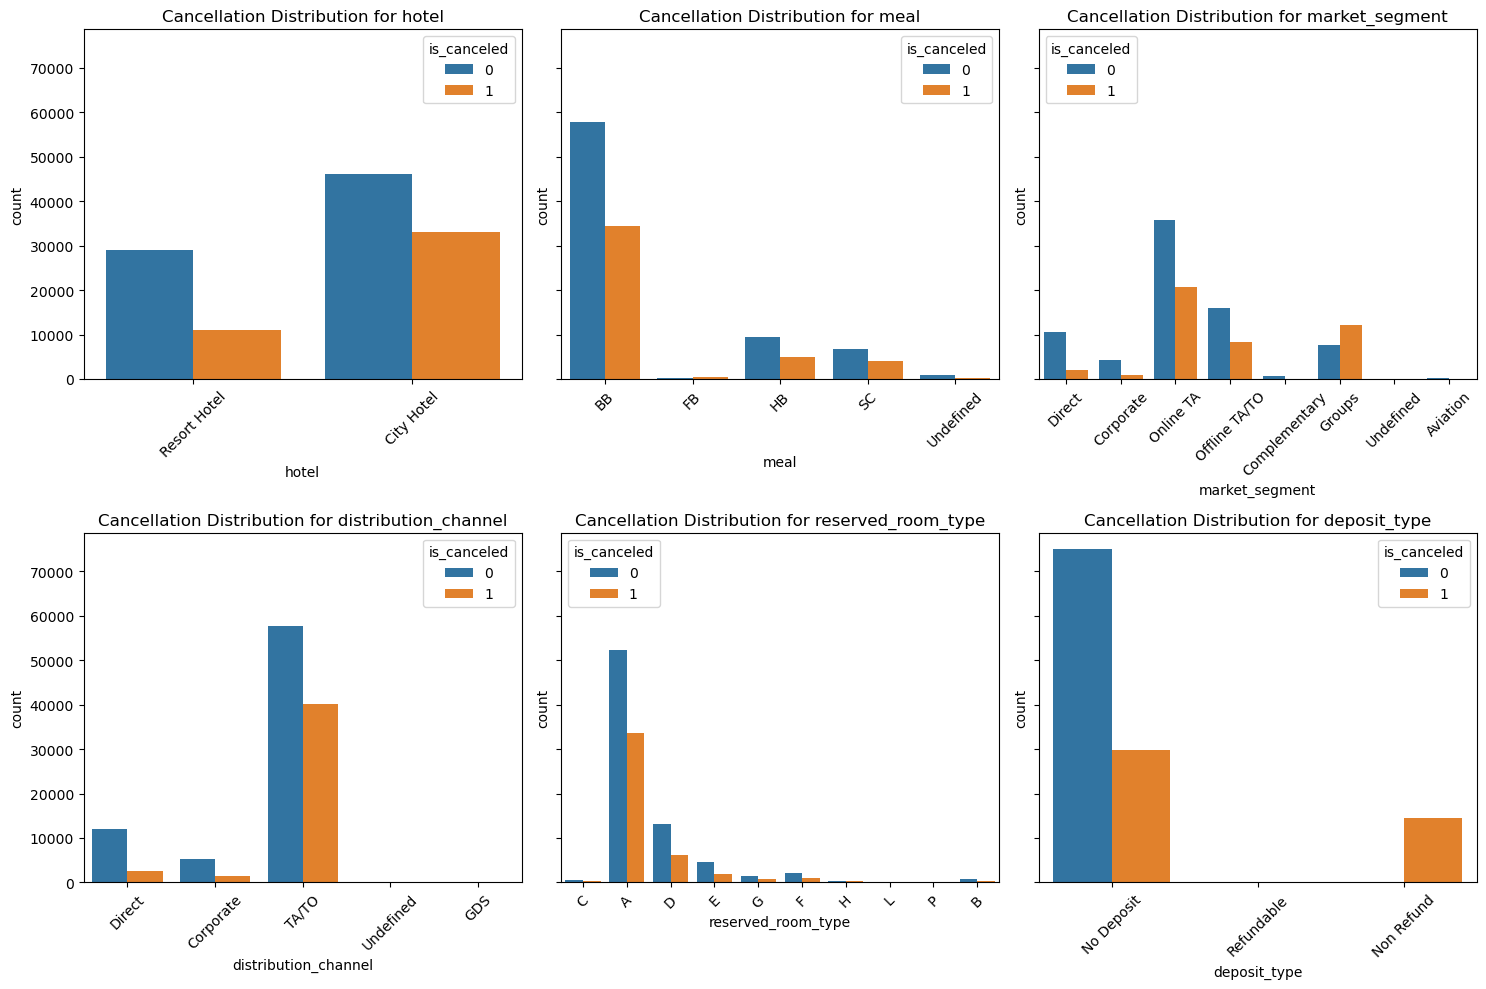

In [7]:
x_values_list = ['hotel', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type']

# Set up subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), sharey=True)
axes = axes.flatten()

# Iterate through the list above and create subplots
for i, x_value in enumerate(x_values_list):
    sns.countplot(x=x_value, hue='is_canceled', data=df, ax=axes[i])
    axes[i].set_title(f'Cancellation Distribution for {x_value}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Numerical Values 

In this section, I dropped columns that were numerical values but should not be treated as such by the model. The variables that remained were: 
1. Lead Time
2. Stays in weekend nights
3. Distribution of Adults
4. Distribution of children
5. Distribution of Babies
6. Previous Cancellations
7. Distribution of Booking Changes
8. Total of Special Requests

After plotting distribution, I noticed that lead time was the only variable that had a wide distribution. 

In [8]:
##Drop columns that should not be treated as numerical values 
df_numerical_values = df.select_dtypes(include=["int64","float64"]).drop(columns = ['arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'company', 'adr', 'agent'])

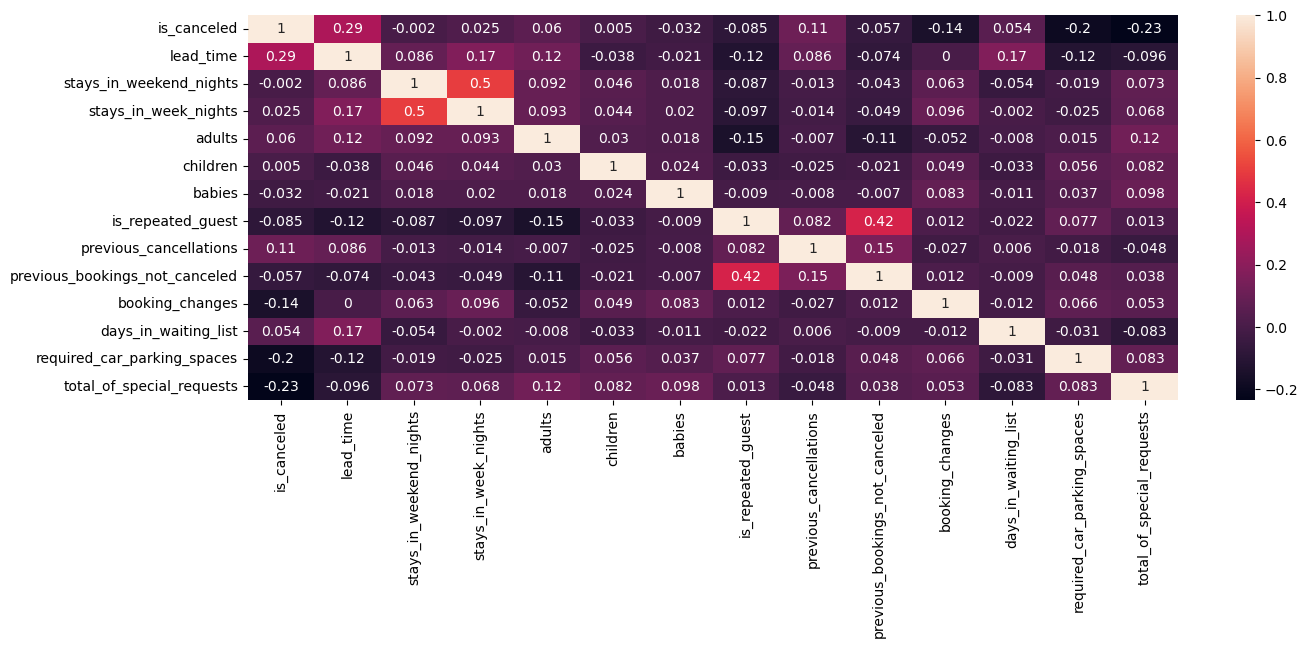

In [9]:
##Create correlation matrix 
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(df_numerical_values.corr().round(decimals=3),annot=True);

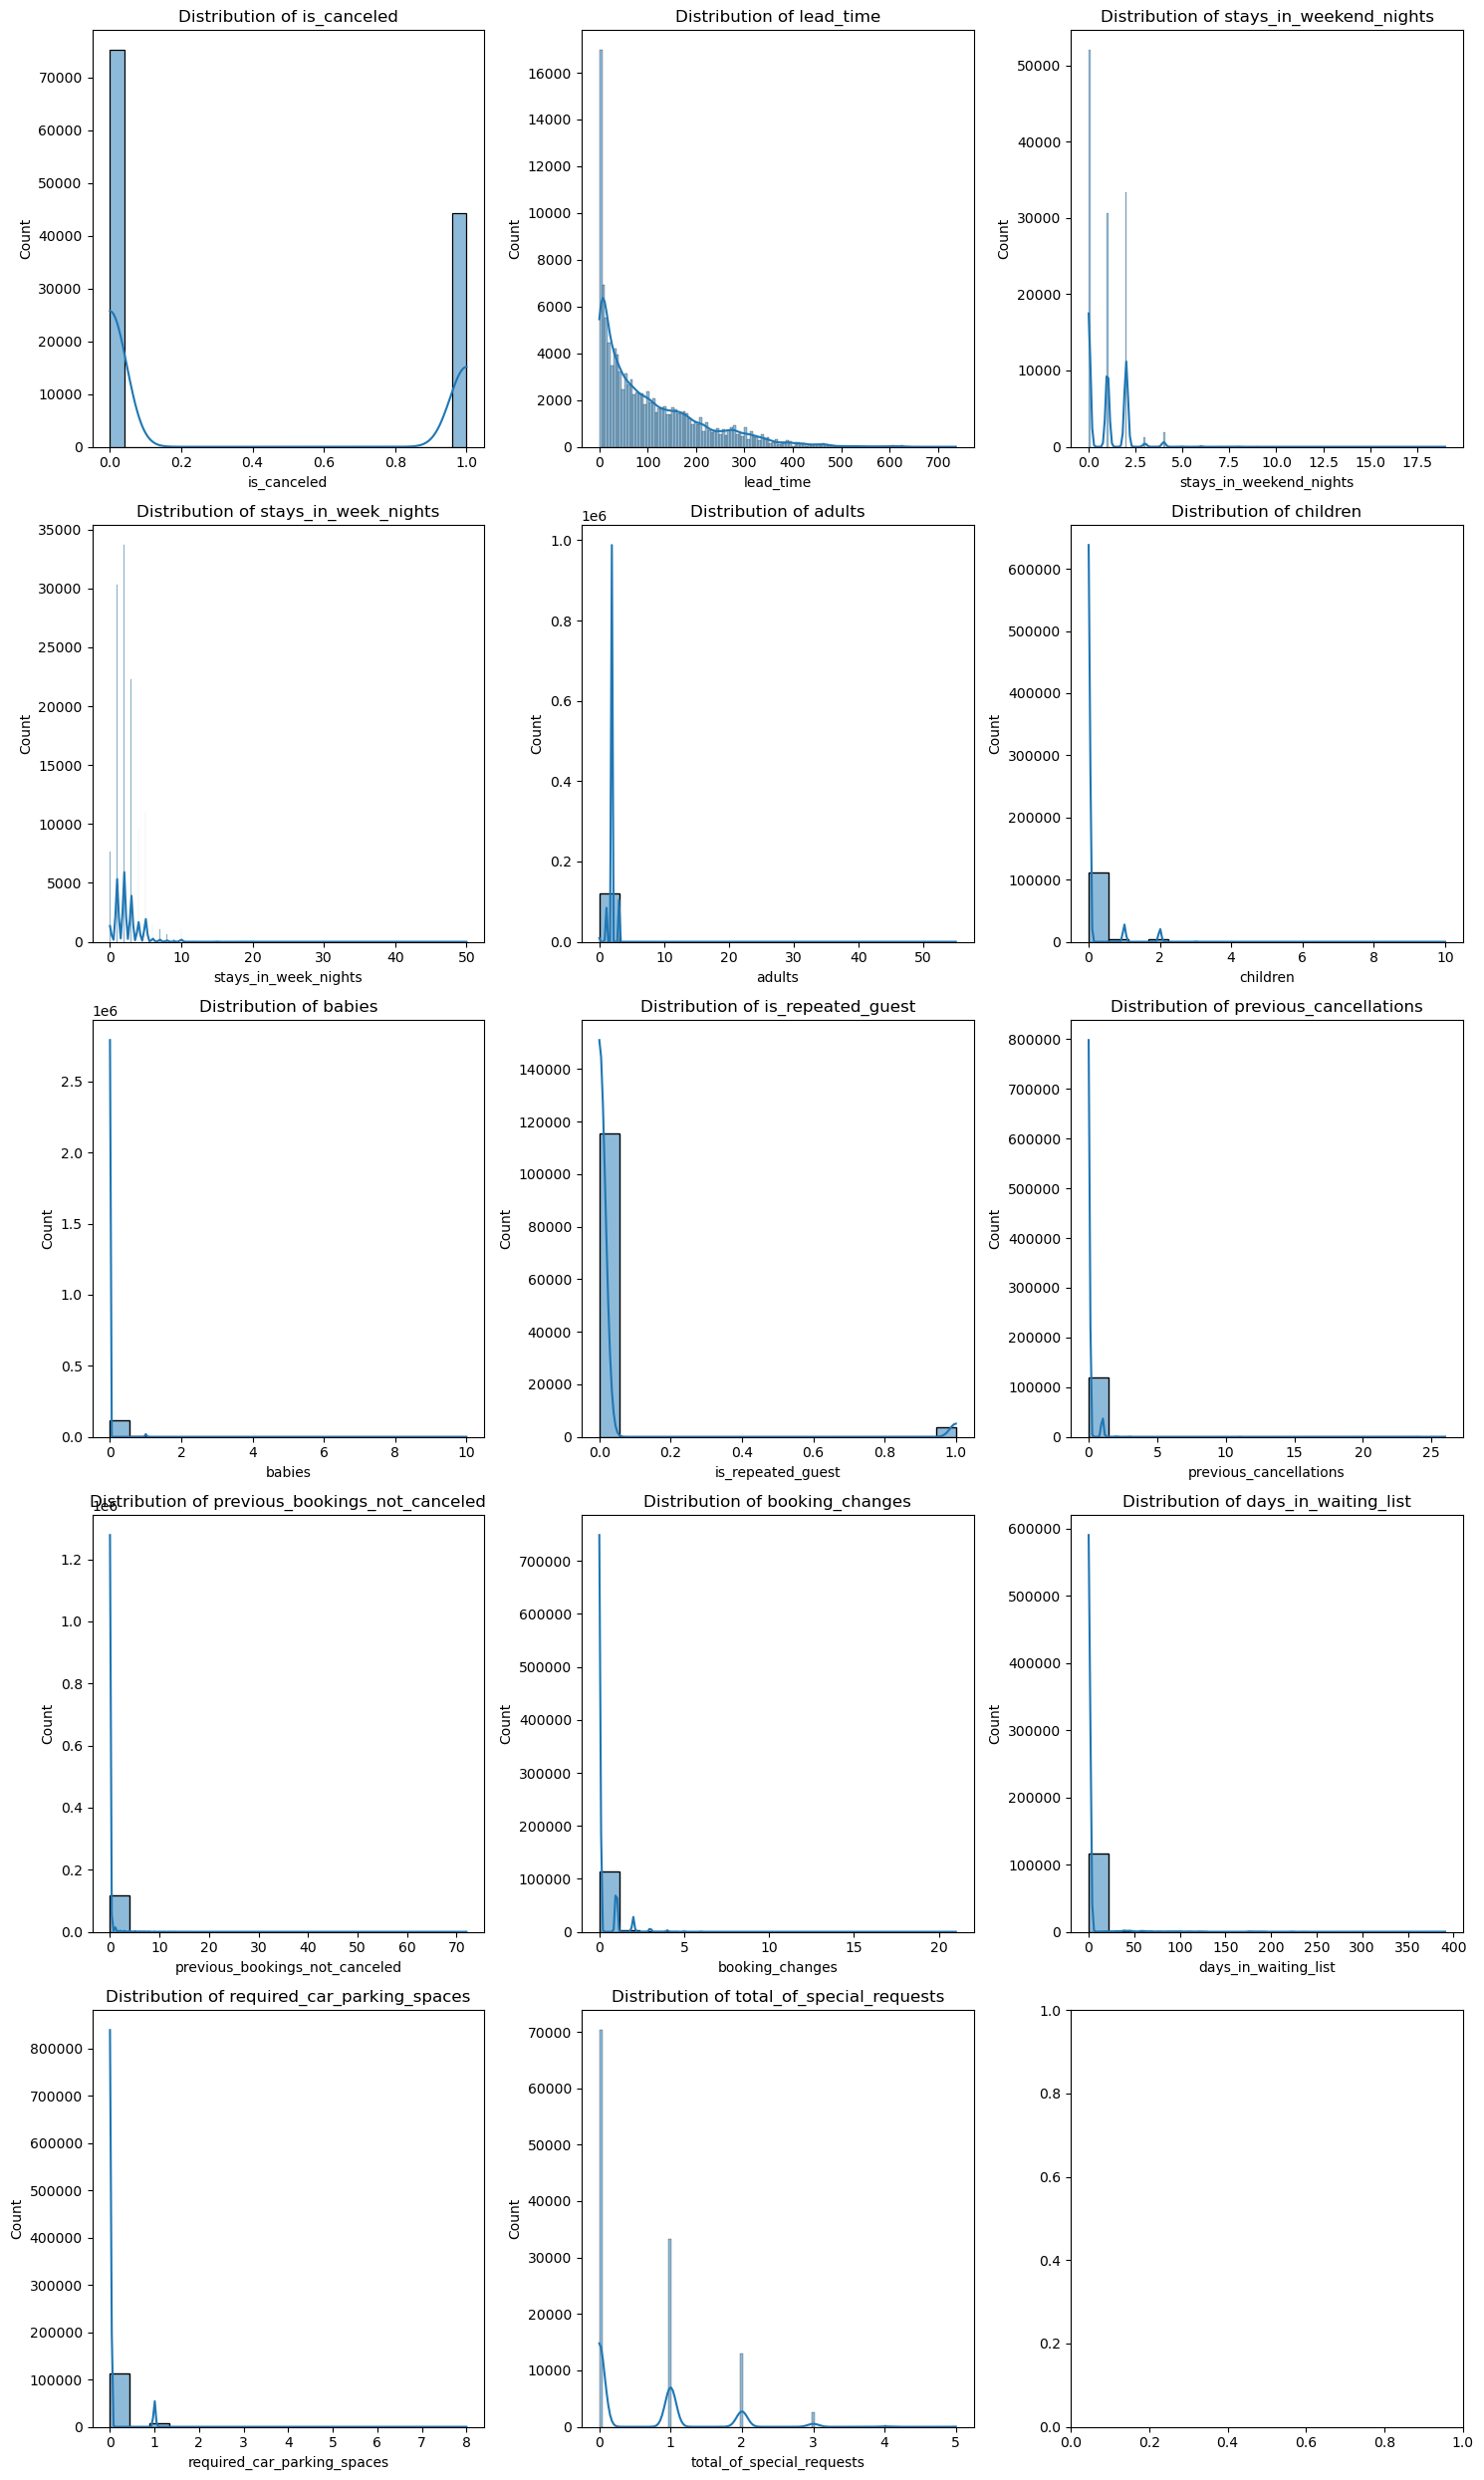

In [10]:
# Set up subplots
fig, axes = plt.subplots(nrows=len(df_numerical_values.columns)//3 + 1, ncols=3, figsize=(15, 5 * (len(df_numerical_values.columns)//3 + 1)))
axes = axes.flatten()

# Iterate through numerical columns and create subplots
for i, col in enumerate(df_numerical_values):
    sns.histplot(df_numerical_values[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

## Data Processing

In this section, I create the dummy variables for the selected categorical variables above. I also handle missing values and wrong datatype in the "childrens" column. 

I then subset the full dataframe to the selected categorical and numerical columns to include in the models. 

In [11]:
# Use pd.get_dummies to create dummy variables
df_dummies = pd.get_dummies(df, columns=['hotel', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type'])

# Display the resulting DataFrame
df_dummies

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable
0,0,342,2015,July,27,1,0,0,2,0.0,...,0,0,0,0,0,0,0,1,0,0
1,0,737,2015,July,27,1,0,0,2,0.0,...,0,0,0,0,0,0,0,1,0,0
2,0,7,2015,July,27,1,0,1,1,0.0,...,0,0,0,0,0,0,0,1,0,0
3,0,13,2015,July,27,1,0,1,1,0.0,...,0,0,0,0,0,0,0,1,0,0
4,0,14,2015,July,27,1,0,2,2,0.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,23,2017,August,35,30,2,5,2,0.0,...,0,0,0,0,0,0,0,1,0,0
119386,0,102,2017,August,35,31,2,5,3,0.0,...,0,1,0,0,0,0,0,1,0,0
119387,0,34,2017,August,35,31,2,5,2,0.0,...,1,0,0,0,0,0,0,1,0,0
119388,0,109,2017,August,35,31,2,5,2,0.0,...,0,0,0,0,0,0,0,1,0,0


In [18]:
selected_columns = ['hotel_City Hotel', 'hotel_Resort Hotel',
       'meal_BB', 'meal_FB', 'meal_HB', 'meal_SC', 'meal_Undefined',
       'market_segment_Aviation', 'market_segment_Complementary',
       'market_segment_Corporate', 'market_segment_Direct',
       'market_segment_Groups', 'market_segment_Offline TA/TO',
       'market_segment_Online TA',
       'distribution_channel_Corporate', 'distribution_channel_Direct',
       'distribution_channel_GDS', 'distribution_channel_TA/TO',
       'reserved_room_type_A',
       'reserved_room_type_B', 'reserved_room_type_C', 'reserved_room_type_D',
       'reserved_room_type_E', 'reserved_room_type_F', 'reserved_room_type_G',
       'reserved_room_type_H', 'reserved_room_type_L', 'reserved_room_type_P',
       'deposit_type_No Deposit', 'deposit_type_Non Refund',
       'deposit_type_Refundable','stays_in_weekend_nights', 'adults', 'children',
                     'babies', 'is_repeated_guest', 'previous_cancellations',
                     'booking_changes', 'total_of_special_requests', 'is_canceled']

subset_df = df_dummies[selected_columns]

# Display the resulting subset DataFrame
subset_df

,hotel_City Hotel,hotel_Resort Hotel,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,...,deposit_type_Refundable,stays_in_weekend_nights,adults,children,babies,is_repeated_guest,previous_cancellations,booking_changes,total_of_special_requests,is_canceled
0,0,1,1,0,0,0,0,0,0,0,...,0,0,2,0.0,0,0,0,3,0,0
1,0,1,1,0,0,0,0,0,0,0,...,0,0,2,0.0,0,0,0,4,0,0
2,0,1,1,0,0,0,0,0,0,0,...,0,0,1,0.0,0,0,0,0,0,0
3,0,1,1,0,0,0,0,0,0,1,...,0,0,1,0.0,0,0,0,0,0,0
4,0,1,1,0,0,0,0,0,0,0,...,0,0,2,0.0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,1,0,1,0,0,0,0,0,0,0,...,0,2,2,0.0,0,0,0,0,0,0
119386,1,0,1,0,0,0,0,0,0,0,...,0,2,3,0.0,0,0,0,0,2,0
119387,1,0,1,0,0,0,0,0,0,0,...,0,2,2,0.0,0,0,0,0,4,0
119388,1,0,1,0,0,0,0,0,0,0,...,0,2,2,0.0,0,0,0,0,0,0


In [19]:
subset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 40 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel_City Hotel                119390 non-null  uint8  
 1   hotel_Resort Hotel              119390 non-null  uint8  
 2   meal_BB                         119390 non-null  uint8  
 3   meal_FB                         119390 non-null  uint8  
 4   meal_HB                         119390 non-null  uint8  
 5   meal_SC                         119390 non-null  uint8  
 6   meal_Undefined                  119390 non-null  uint8  
 7   market_segment_Aviation         119390 non-null  uint8  
 8   market_segment_Complementary    119390 non-null  uint8  
 9   market_segment_Corporate        119390 non-null  uint8  
 10  market_segment_Direct           119390 non-null  uint8  
 11  market_segment_Groups           119390 non-null  uint8  
 12  market_segment_O

In [20]:
subset_df =subset_df.dropna()

In [21]:
subset_df['children'] = subset_df['children'].astype(int)

C:\Users\AngelaLOYOLA\AppData\Local\Temp\ipykernel_15496\2866082383.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Baseline Model: Regular DecisionTreeClassifier

In this section, I will build a regular decsion tress to establish a baseline to measure performance of the classifier in further interations. 

This section performs and train, test, split with a test size of 25% and using a random state to ensure the model results are reproducible. 

In [49]:
subset = subset_df.drop(columns = 'is_canceled')
target = subset_df['is_canceled']

In [50]:
data_train, data_test, target_train, target_test = train_test_split(subset, target, test_size = .25, random_state = 123)

In [51]:
tree_clf = DecisionTreeClassifier(criterion = 'gini')
tree_clf.fit(data_train, target_train)

DecisionTreeClassifier()

In [52]:
def get_top_features(model, data_train, top_n=10):
    feature_importances = model.feature_importances_
    sorted_indices = np.argsort(feature_importances)[::-1]
    
    top_feature_indices = sorted_indices[:top_n]
    top_features = data_train.columns.values[top_feature_indices]
    top_importances = feature_importances[top_feature_indices]

    return list(zip(top_features, top_importances))

# Example usage:
top_features = get_top_features(tree_clf, data_train)
print("Top 10 Features and Importances:")
for feature, importance in top_features:
    print(f"{feature}: {importance}")

Top 10 Features and Importances:
deposit_type_Non Refund: 0.49965518102793705
total_of_special_requests: 0.1042616262392903
market_segment_Online TA: 0.07895709595737414
previous_cancellations: 0.06795590513197552
stays_in_weekend_nights: 0.040874271634068766
adults: 0.03160808124426461
booking_changes: 0.03113618376509019
distribution_channel_Corporate: 0.021212945866830545
children: 0.013760823046812216
reserved_room_type_D: 0.009019534396763205


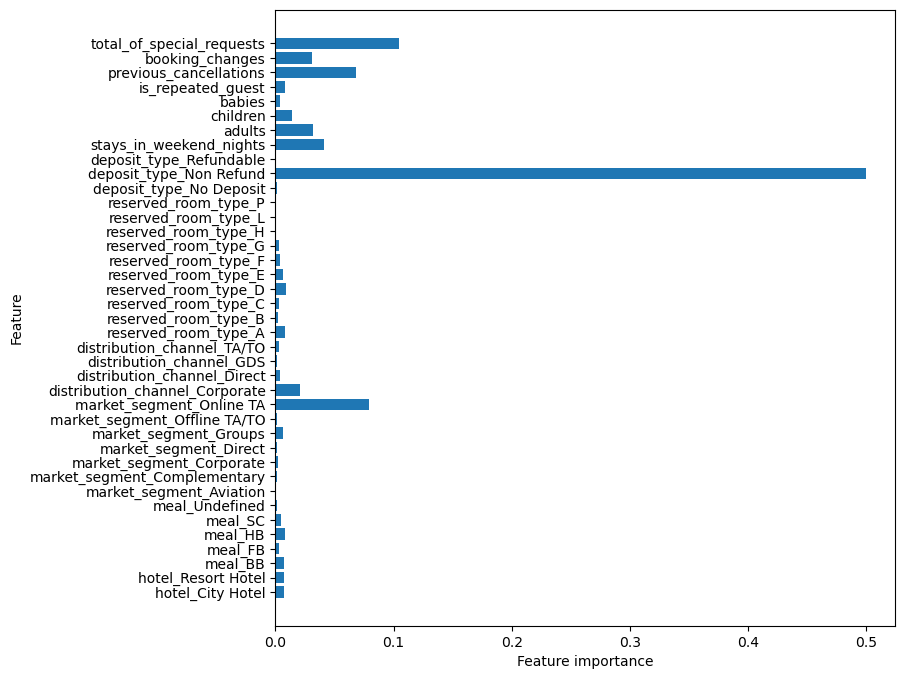

In [53]:
def plot_feature_importances(model):
    n_features = data_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), data_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(tree_clf)

In [54]:
# Test set predictions
pred = tree_clf.predict(data_test)

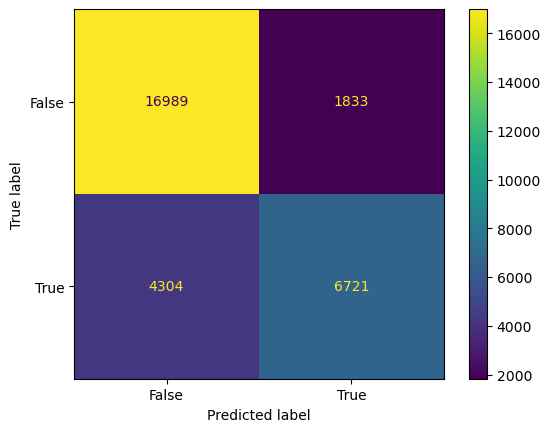

In [55]:
##Favor for Prediciting Class 0 so I think I need to implement Smote before calling random forest

from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(target_test, pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [56]:
print(classification_report(target_test, pred))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85     18822
           1       0.79      0.61      0.69     11025

    accuracy                           0.79     29847
   macro avg       0.79      0.76      0.77     29847
weighted avg       0.79      0.79      0.79     29847



## Random Forest Model

The next model uses Grid Search with Random Forests that aggregates multiple decision trees and potentially mitigate the risk of individual trees making biased predictions. 

Uses SMOTE to account for Class Imbalance 
improves recall by 8 percentage points

In [57]:
rf_clf = RandomForestClassifier()

In [58]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
data_train_resampled, target_train_resampled = smote.fit_resample(data_train, target_train)

In [59]:
rf_clf.fit(data_train_resampled, target_train_resampled)

RandomForestClassifier()

In [60]:
top_features = get_top_features(rf_clf, data_train)
print("Top 10 Features and Importances:")
for feature, importance in top_features:
    print(f"{feature}: {importance}")

Top 10 Features and Importances:
deposit_type_Non Refund: 0.19665666657779424
deposit_type_No Deposit: 0.1377675136322326
total_of_special_requests: 0.1309321385717232
previous_cancellations: 0.08344121313916009
booking_changes: 0.06644984880387944
stays_in_weekend_nights: 0.06325071780827773
market_segment_Online TA: 0.054158991530113276
adults: 0.03674721684254998
market_segment_Offline TA/TO: 0.027248246856037443
market_segment_Groups: 0.024469815778438434


In [61]:
pred_rf_clf = rf_clf.predict(data_test)

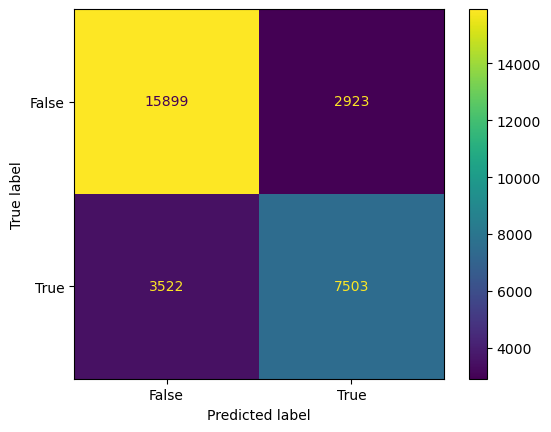

In [62]:
confusion_matrix = metrics.confusion_matrix(target_test, pred_rf_clf)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [63]:
print(classification_report(target_test, pred_rf_clf))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83     18822
           1       0.72      0.68      0.70     11025

    accuracy                           0.78     29847
   macro avg       0.77      0.76      0.77     29847
weighted avg       0.78      0.78      0.78     29847



## Random Forest Model with Grid Search

In [64]:
rf_clf_grid = RandomForestClassifier()

In [76]:
rf_param_grid = {
    "n_estimators": [10, 30, 100],
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 2, 6, 10, 18],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [3, 6],
}

In [ ]:
Stop

In [77]:
rf_grid_search = GridSearchCV(rf_clf_grid, rf_param_grid, cv=3)
rf_grid_search.fit(data_train_resampled, target_train_resampled)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Training Accuracy: 76.72%

Optimal Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}


In [65]:
rf_clf_grid = RandomForestClassifier(criterion= 'gini', max_depth =None, min_samples_leaf= 3, min_samples_split= 10, n_estimators = 100)

In [66]:
rf_clf_grid.fit(data_train_resampled, target_train_resampled)

RandomForestClassifier(min_samples_leaf=3, min_samples_split=10)

In [67]:
rf_grid_pred = rf_clf_grid.predict(data_test)

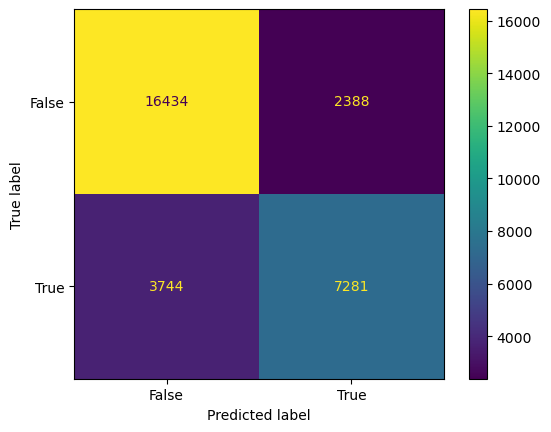

In [68]:
confusion_matrix = metrics.confusion_matrix(target_test, rf_grid_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [69]:
print(classification_report(target_test, rf_grid_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84     18822
           1       0.75      0.66      0.70     11025

    accuracy                           0.79     29847
   macro avg       0.78      0.77      0.77     29847
weighted avg       0.79      0.79      0.79     29847



In [70]:
top_features = get_top_features(rf_clf_grid, data_train)
print("Top 10 Features and Importances:")
for feature, importance in top_features:
    print(f"{feature}: {importance}")

Top 10 Features and Importances:
deposit_type_Non Refund: 0.19516328547270267
deposit_type_No Deposit: 0.17322277404349543
total_of_special_requests: 0.13867484389906365
previous_cancellations: 0.08759937423538997
booking_changes: 0.06345420201610245
market_segment_Online TA: 0.06002388808280874
stays_in_weekend_nights: 0.03285153781048685
market_segment_Groups: 0.030643438027891153
market_segment_Offline TA/TO: 0.030342371962330642
adults: 0.026303982046090482


In [ ]:
##Recall went down 2 points but overall accuracy went up 2 points 

### Random Forest: Only Important Features

In [71]:
# Assuming `get_top_features` function returns a list of tuples [(feature_name, importance)]
top_features = get_top_features(rf_clf_grid, data_train)
# Extracting feature names from the list of tuples
top_feature_names = [feature for feature, _ in top_features]

# Filter the training data to include only the top features
filtered_data_train = data_train_resampled[top_feature_names]

# Train the Random Forest model using only the top features
rf_clf_test = RandomForestClassifier()  # You can adjust parameters as needed
rf_clf_test.fit(filtered_data_train, target_train_resampled)  # Assuming target_variable is your target variable

print("Top Features and Importances:")
for feature, importance in top_features:
    print(f"{feature}: {importance}")

Top Features and Importances:
deposit_type_Non Refund: 0.19516328547270267
deposit_type_No Deposit: 0.17322277404349543
total_of_special_requests: 0.13867484389906365
previous_cancellations: 0.08759937423538997
booking_changes: 0.06345420201610245
market_segment_Online TA: 0.06002388808280874
stays_in_weekend_nights: 0.03285153781048685
market_segment_Groups: 0.030643438027891153
market_segment_Offline TA/TO: 0.030342371962330642
adults: 0.026303982046090482


In [74]:
filtered_data_test = data_test[top_feature_names]

In [76]:
rf_grid_test_pred = rf_clf_test.predict(filtered_data_test)

In [78]:
print(classification_report(target_test, rf_grid_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84     18822
           1       0.75      0.64      0.69     11025

    accuracy                           0.79     29847
   macro avg       0.78      0.76      0.76     29847
weighted avg       0.78      0.79      0.78     29847



In [ ]:
##Recall is also down I don't know if this model is worth it

### Selecting Final Model

Text(0.5, 1.0, 'Model Performance')

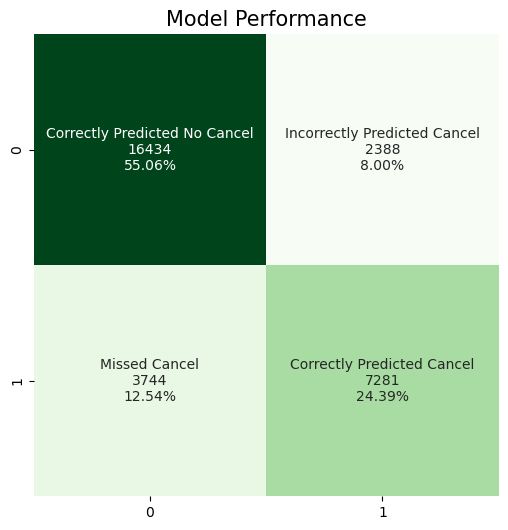

In [81]:
#Create plot
fig, ax=plt.subplots(figsize=(6,6))

#Get predictions and confusion matrix
y_pred = rf_clf_grid.predict(data_test)
cf_matrix = metrics.confusion_matrix(target_test, y_pred)

#Set group names and % of values
group_names = ["Correctly Predicted No Cancel","Incorrectly Predicted Cancel","Missed Cancel","Correctly Predicted Cancel"]
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]                
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
                    
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in  zip(group_names,group_counts,group_percentages)]         
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens',ax=ax,cbar=False)


ax.set_title("Model Performance",fontsize=15)

In [ ]:
#